Quick GP notes from lect

- length scale and amplitude of RBF are parameters that need to be optimized
- set initial noise level high even if you think your data have low noise

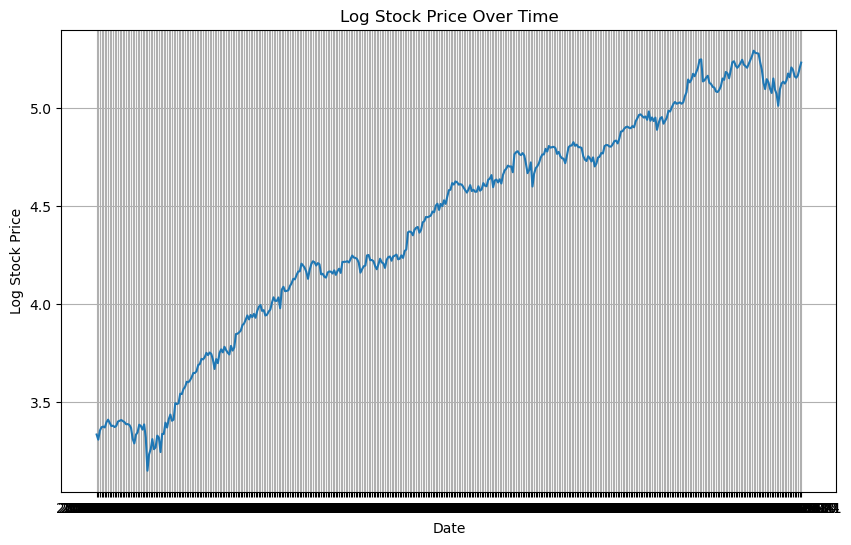

datetime64[ns]


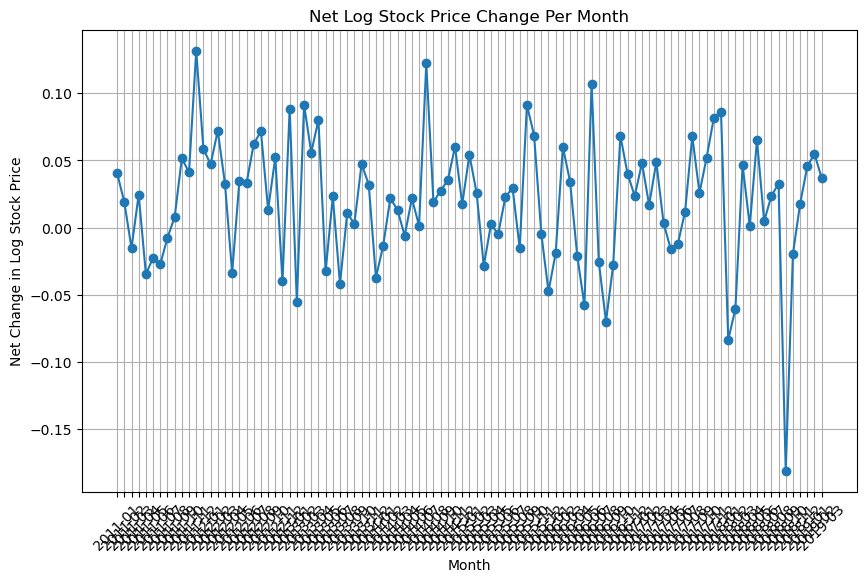

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# 
df = pd.read_csv("./midterm_data/data_train_midterm_problem1.csv")
df['log_stock_price'] = np.log(df['stock_price'])
df['raw_change'] = df['stock_price'].diff()
df['log_change'] = df['log_stock_price'].diff()
#
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['log_stock_price'])
plt.title('Log Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Log Stock Price')
plt.grid(True)
plt.show()
#
# plot average stock price for each month
# calculate net change in stock price per month 
df['date'] = pd.to_datetime(df['date'])
print(df['date'].dtype)
df['year_month'] = df['date'].dt.to_period('M')
month_means = df.groupby('year_month')['stock_price'].mean().reset_index()
month_changes = df.groupby('year_month')['log_change'].sum().reset_index()
#
plt.figure(figsize=(10, 6))
plt.plot(month_changes['year_month'].astype(str), month_changes['log_change'], marker='o')
plt.title('Net Log Stock Price Change Per Month')
plt.xlabel('Month')
plt.ylabel('Net Change in Log Stock Price')
plt.xticks(rotation=45)
plt.grid(True)
 # plt.show()

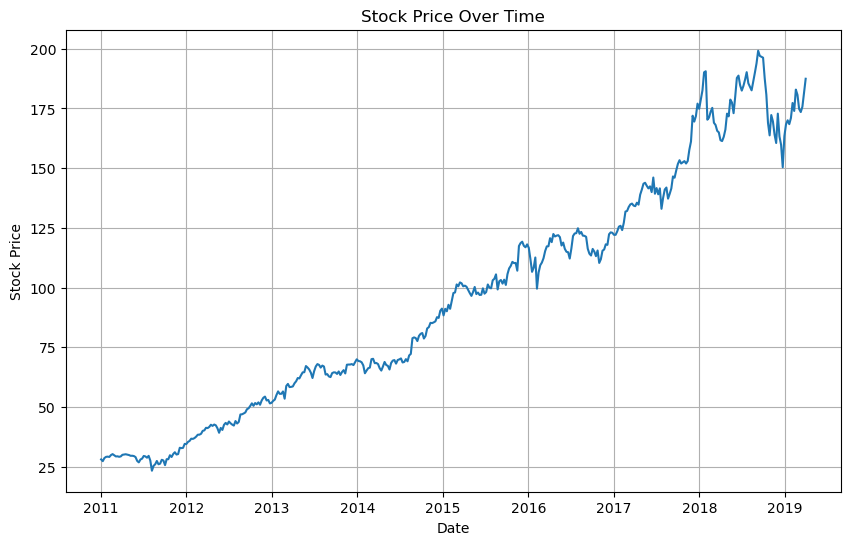

In [12]:
import matplotlib.pyplot as plt

# Plot stock prices
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['stock_price'])
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

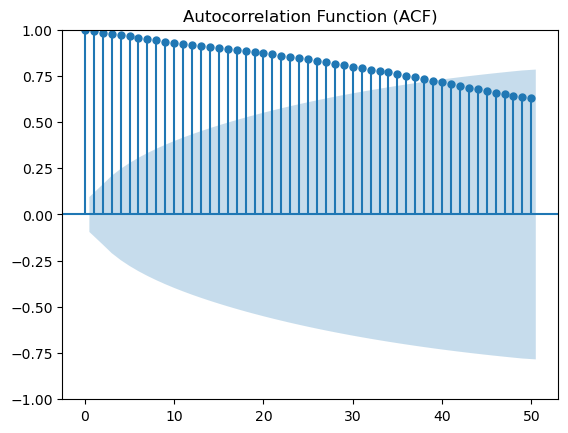

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function for the stock prices
plot_acf(df['stock_price'], lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()


In [14]:
## CHUNK DATA FRAME BEFORE CROSS VALIDATION STEP - I WANT A HOLDOUT SET ##
from sklearn.model_selection import train_test_split

# Split 
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
## train_df.head()

### Setting up a GP model

# convert datetime column to continuous so that it can be worked with more easily, as done in the volcano sklearn example
df['date'] = pd.to_datetime(df['date'])
reference_date = df['date'].min()
df['days_since_start'] = (df['date'] - reference_date).dt.days

# define data
x = df['days_since_start']
y = df['log_stock_price']

# split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [15]:
### Setting up a GP model

# convert datetime column to continuous so that it can be worked with more easily, as done in the volcano sklearn example
df['date'] = pd.to_datetime(df['date'])
reference_date = df['date'].min()
df['days_since_start'] = (df['date'] - reference_date).dt.days

# define data
x = df['days_since_start'].values.reshape(-1, 1)
y = df['log_stock_price']

# split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### define kernel and mean functions
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

length = 50
k1 =  50.0**2 * RBF(length)
k2 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

# define mixed kernel
kernel = ( k1 + k2 )
#

## Train model and make predictions
y_mean = 0
gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
gaussian_process.fit(X_train, y_train - y_mean)
y_pred, y_std = gaussian_process.predict(X_test, return_std=True)

# PLOT THE RESULTS
#plt.figure(figsize=(10, 6))
# plt.scatter(df['days_since_start'], df['log_stock_price'], label='Original Data', color='black', s=10)



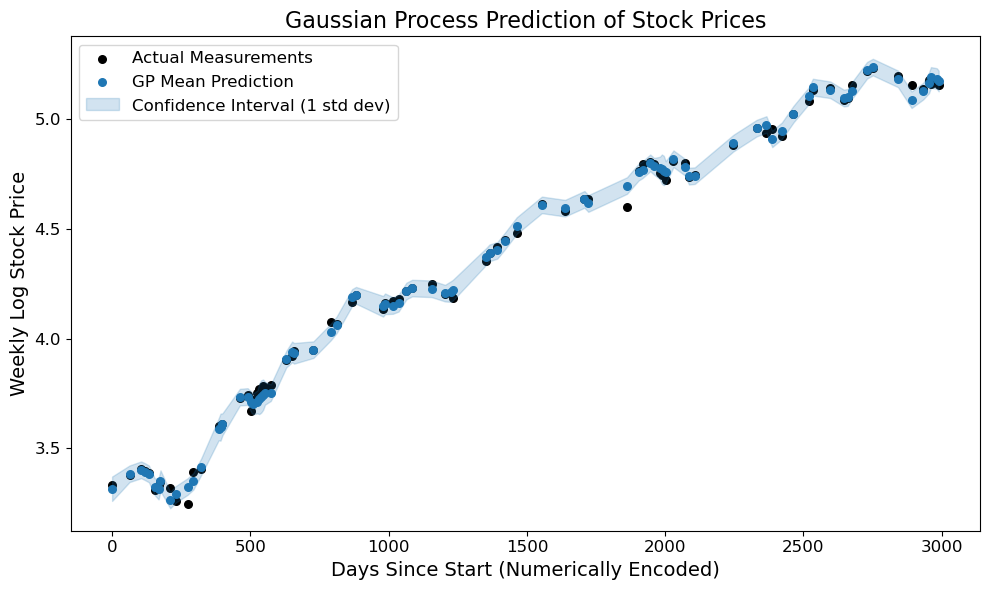

In [16]:
## Train model and make predictions
y_mean = 0
gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
gaussian_process.fit(X_train, y_train - y_mean)
y_pred, y_std = gaussian_process.predict(X_test, return_std=True)

mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
# using a mean function of 0 seems to work pretty well

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color="black", s=30, marker='o', label="Actual Measurements")

plt.scatter(X_test, mean_y_pred, color="tab:blue", s=30, marker='o', label="GP Mean Prediction")


sorted_indices = np.argsort(X_test.ravel())
X_test_sorted = X_test.ravel()[sorted_indices]
mean_y_pred_sorted = mean_y_pred[sorted_indices]
std_y_pred_sorted = std_y_pred[sorted_indices]

plt.fill_between(
    X_test_sorted,
    mean_y_pred_sorted - 2*std_y_pred_sorted,
    mean_y_pred_sorted + 2*std_y_pred_sorted,
    color="tab:blue",
    alpha=0.2,
    label="Confidence Interval (1 std dev)"
)

plt.legend(fontsize=12, loc='upper left')

plt.xlabel("Days Since Start (Numerically Encoded)", fontsize=14)
plt.ylabel("Weekly Log Stock Price", fontsize=14)
plt.title("Gaussian Process Prediction of Stock Prices", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# 
plt.show()

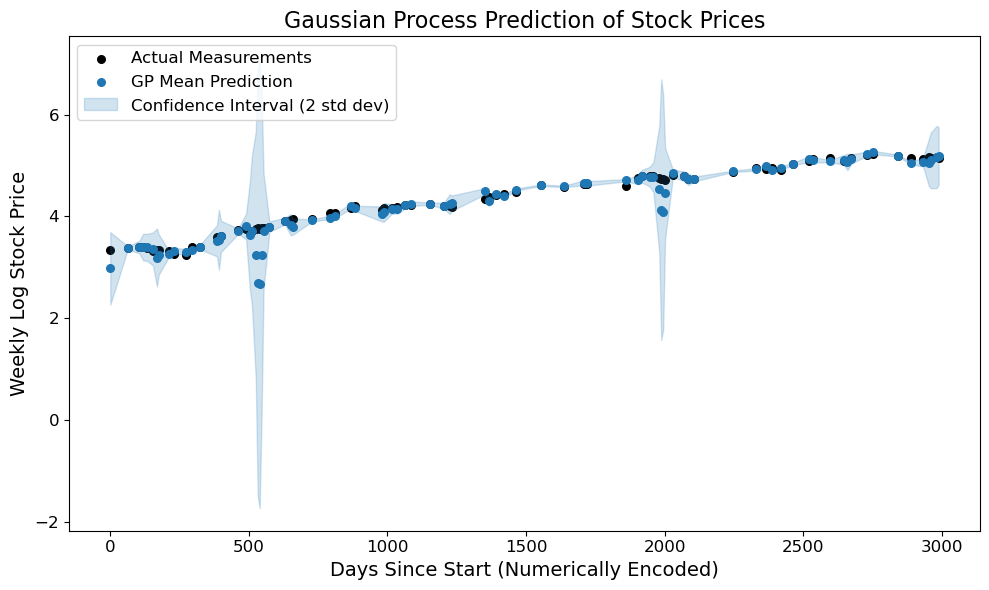

In [17]:
### RBF KERNEL ONLY TEST
length = 17
k1 =  50**2 * RBF(length)
## Train model and make predictions
y_mean = 0
gaussian_process = GaussianProcessRegressor(kernel=k1, normalize_y=False)
gaussian_process.fit(X_train, y_train - y_mean)
y_pred, y_std = gaussian_process.predict(X_test, return_std=True)

mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
# using a mean function of 0 seems to work pretty well

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color="black", s=30, marker='o', label="Actual Measurements")

plt.scatter(X_test, mean_y_pred, color="tab:blue", s=30, marker='o', label="GP Mean Prediction")


sorted_indices = np.argsort(X_test.ravel())
X_test_sorted = X_test.ravel()[sorted_indices]
mean_y_pred_sorted = mean_y_pred[sorted_indices]
std_y_pred_sorted = std_y_pred[sorted_indices]

plt.fill_between(
    X_test_sorted,
    mean_y_pred_sorted - 2*std_y_pred_sorted,
    mean_y_pred_sorted + 2*std_y_pred_sorted,
    color="tab:blue",
    alpha=0.2,
    label="Confidence Interval (2 std dev)"
)

plt.legend(fontsize=12, loc='upper left')

plt.xlabel("Days Since Start (Numerically Encoded)", fontsize=14)
plt.ylabel("Weekly Log Stock Price", fontsize=14)
plt.title("Gaussian Process Prediction of Stock Prices", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# 
plt.show()

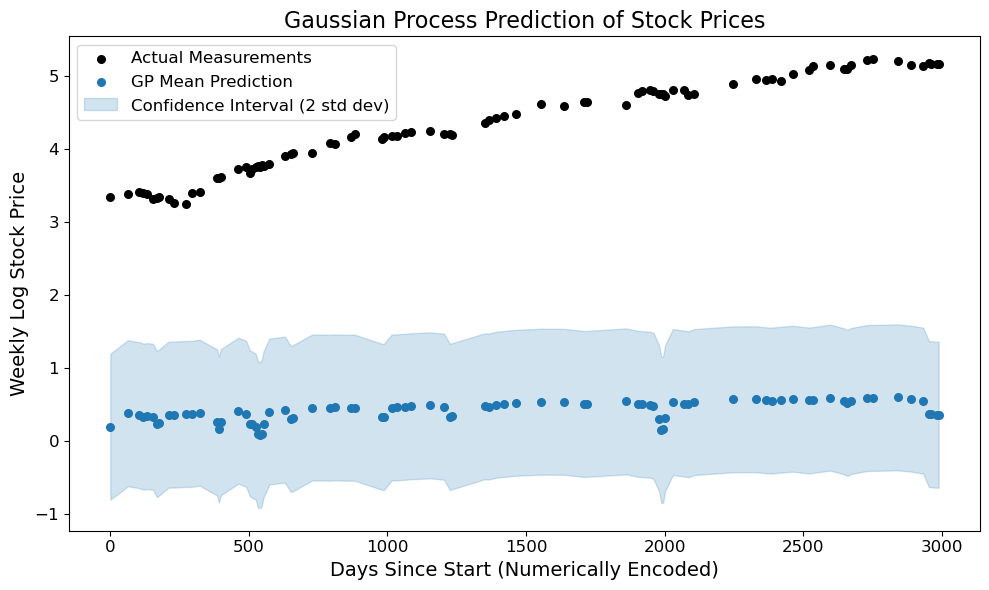

In [18]:
### RATIONAL QUADRATIC ONLY TEST ###
k2 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
## Train model and make predictions
y_mean = 0
gaussian_process = GaussianProcessRegressor(kernel=k2, normalize_y=False)
gaussian_process.fit(X_train, y_train - y_mean)
y_pred, y_std = gaussian_process.predict(X_test, return_std=True)

mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
# using a mean function of 0 seems to work pretty well

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color="black", s=30, marker='o', label="Actual Measurements")

plt.scatter(X_test, mean_y_pred, color="tab:blue", s=30, marker='o', label="GP Mean Prediction")


sorted_indices = np.argsort(X_test.ravel())
X_test_sorted = X_test.ravel()[sorted_indices]
mean_y_pred_sorted = mean_y_pred[sorted_indices]
std_y_pred_sorted = std_y_pred[sorted_indices]

plt.fill_between(
    X_test_sorted,
    mean_y_pred_sorted - 2*std_y_pred_sorted,
    mean_y_pred_sorted + 2*std_y_pred_sorted,
    color="tab:blue",
    alpha=0.2,
    label="Confidence Interval (2 std dev)"
)

plt.legend(fontsize=12, loc='upper left')

plt.xlabel("Days Since Start (Numerically Encoded)", fontsize=14)
plt.ylabel("Weekly Log Stock Price", fontsize=14)
plt.title("Gaussian Process Prediction of Stock Prices", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# 
plt.show()

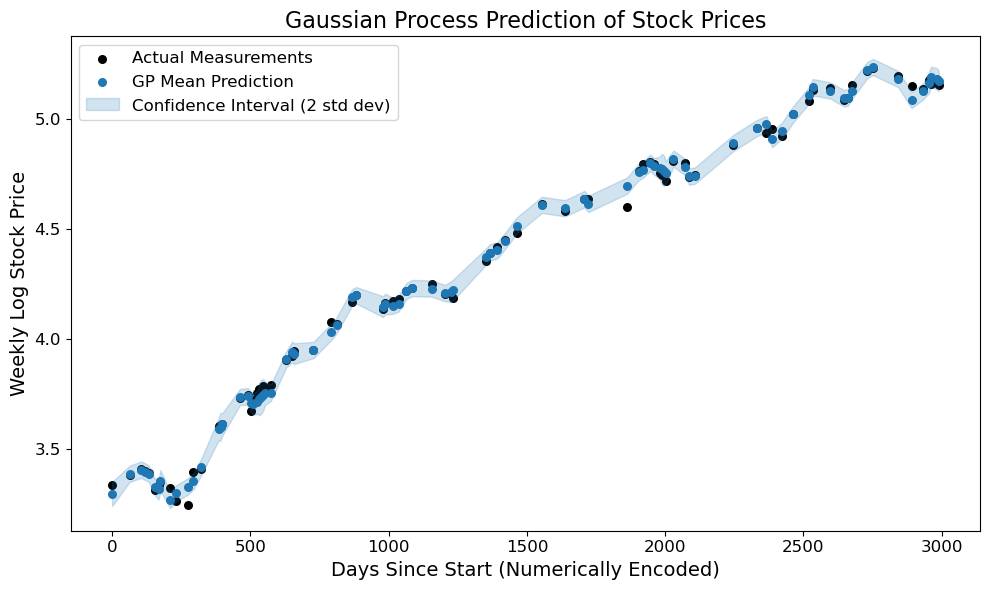

In [39]:
### define data
# convert datetime column to continuous so that it can be worked with more easily, as done in the volcano sklearn example
df['date'] = pd.to_datetime(df['date'])
reference_date = df['date'].min()
df['days_since_start'] = (df['date'] - reference_date).dt.days

# define data
x = df['days_since_start'].values.reshape(-1, 1)
y = df['log_stock_price']

# split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


### define kernel and mean functions
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel 

## CHOOSE YOUR KERNEL - WITH periodicity 
length = 50
k1 =  50.0**2 * RBF(length)
k2 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k3 = (
    5.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
k4 = noise_kernel = 0.1**2 * RBF(length_scale=5) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
# define mixed kernel
kernel = ( k1 + k2 + k3 + k4)
kernel = k1 * k2
#

# PLOT THE RESULTS
#plt.figure(figsize=(10, 6))
# plt.scatter(df['days_since_start'], df['log_stock_price'], label='Original Data', color='black', s=10)

## Train model and make predictions
y_mean = 0
gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
gaussian_process.fit(X_train, y_train - y_mean)
y_pred, y_std = gaussian_process.predict(X_test, return_std=True)

mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
# using a mean function of 0 seems to work pretty well

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color="black", s=30, marker='o', label="Actual Measurements")

plt.scatter(X_test, mean_y_pred, color="tab:blue", s=30, marker='o', label="GP Mean Prediction")


sorted_indices = np.argsort(X_test.ravel())
X_test_sorted = X_test.ravel()[sorted_indices]
mean_y_pred_sorted = mean_y_pred[sorted_indices]
std_y_pred_sorted = std_y_pred[sorted_indices]

plt.fill_between(
    X_test_sorted,
    mean_y_pred_sorted - 2*std_y_pred_sorted,
    mean_y_pred_sorted + 2*std_y_pred_sorted,
    color="tab:blue",
    alpha=0.2,
    label="Confidence Interval (2 std dev)"
)

plt.legend(fontsize=12, loc='upper left')

plt.xlabel("Days Since Start (Numerically Encoded)", fontsize=14)
plt.ylabel("Weekly Log Stock Price", fontsize=14)
plt.title("Gaussian Process Prediction of Stock Prices", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# 
plt.show()

Given the hint in problem 1b, we know that cross-validation has to be done differently than just chunking up the training data into random folds. Since each observation depends on the previous, I will use the time series split function in Sklearn to examine the recommended 5 folds. Thus, the model will be sequentially trained on k folds where the k+1th fold is used as the testing set. 

In [88]:
from sklearn.model_selection import TimeSeriesSplit as tss 
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ExpSineSquared, RationalQuadratic
from sklearn.metrics import mean_squared_error

## CHOOSE YOUR KERNEL
# use an RBF kernel with fat length scale 
length = 50
k1 =  50.0**2 * RBF(length)
# use a rational quadratic kernel to model local noise
k2 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
# use a periodic
k3 = (
    5.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
k4 = noise_kernel = 0.1**2 * RBF(length_scale=5) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
# define mixed kernel
kernel = ( k1 + k2 + k3 + k4)

# define input data:
df1 = pd.read_csv("./midterm_data/data_train_midterm_problem1.csv")
df1['log_stock_price'] = np.log(df['stock_price'])
df1['raw_change'] = df['stock_price'].diff()
df1['log_change'] = df['log_stock_price'].diff()
#
df1['date'] = pd.to_datetime(df1['date'])
reference_date = df1['date'].min()
df1['days_since_start'] = (df1['date'] - reference_date).dt.days
#
x = df1['days_since_start'].values.reshape(-1, 1)
y = df1['log_stock_price']

# define lists to keep track of params during cross val 
params = []
lml = []
mse = []
splitcv = tss(n_splits=10)
for train_index, test_index in splitcv.split(x):
    # define training and testing input vars for each iteration of the loop 
    # ie indices defined for a given fold from 1-5 
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_mean = np.mean(y_train)
    # define and train gpmodel for each iter
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
    gaussian_process.fit(x_train, y_train - y_mean)

    # extract param values
    kernel_params = gaussian_process.kernel_
    params.append(kernel_params)
    # make predictions
    y_pred, y_std = gaussian_process.predict(x_test, return_std=True)
    y_pred += y_mean
    #
    params.append(gaussian_process.kernel_)
    mse.append(mean_squared_error(y_test, y_pred))
    lml.append(gaussian_process.log_marginal_likelihood_value_)

min_mse_idx = np.argmin(mse)
max_lml_idx = np.argmax(lml)


In [96]:
# Print the structure of one of the kernel objects to see how to access the parameters
print(params[0])

0.0354**2 * RBF(length_scale=61.4) + 0.0133**2 * RationalQuadratic(alpha=0.878, length_scale=0.0163) + 0.0403**2 * RBF(length_scale=6.85) * ExpSineSquared(length_scale=1.36e-05, periodicity=1) + 0.0091**2 * RBF(length_scale=0.00198) + WhiteKernel(noise_level=3.92e-05)


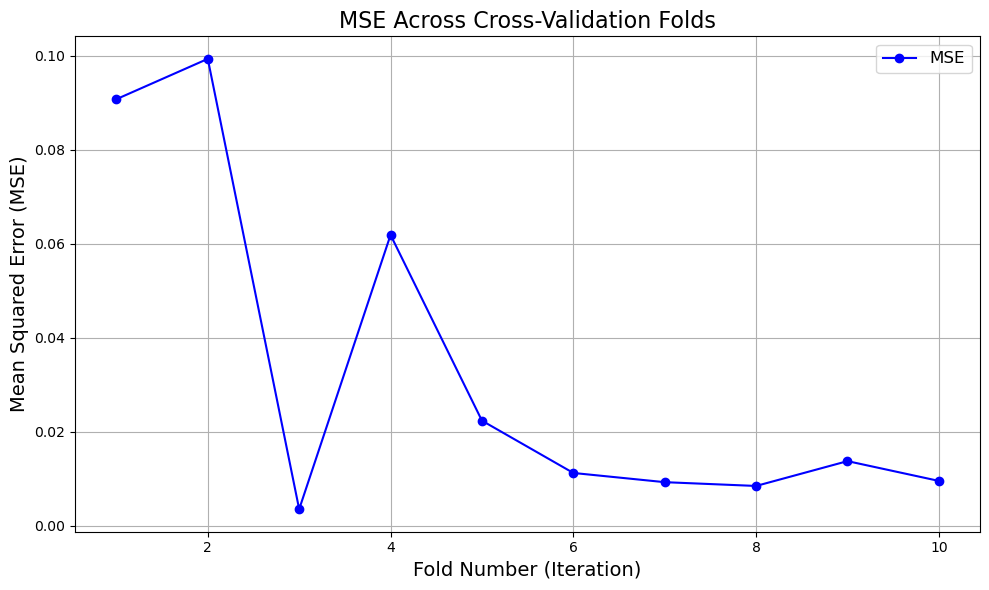

Best fold number: 3
Kernel parameters from best fold: 0.38**2 * RBF(length_scale=481) + 0.0278**2 * RationalQuadratic(alpha=2.34, length_scale=6.73) + 0.081**2 * RBF(length_scale=87.8) * ExpSineSquared(length_scale=339, periodicity=1) + 0.0152**2 * RBF(length_scale=1.71e-05) + WhiteKernel(noise_level=2.22e-05)


In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Find the index of the fold with the lowest MSE
min_mse_idx = np.argmin(mse)

# Plot MSE across the folds
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse) + 1), mse, marker='o', linestyle='-', color='blue', label='MSE')
plt.xlabel('Fold Number (Iteration)', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('MSE Across Cross-Validation Folds', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best fold number: {min_mse_idx + 1}")
print(f"Kernel parameters from best fold: {params[min_mse_idx]}")


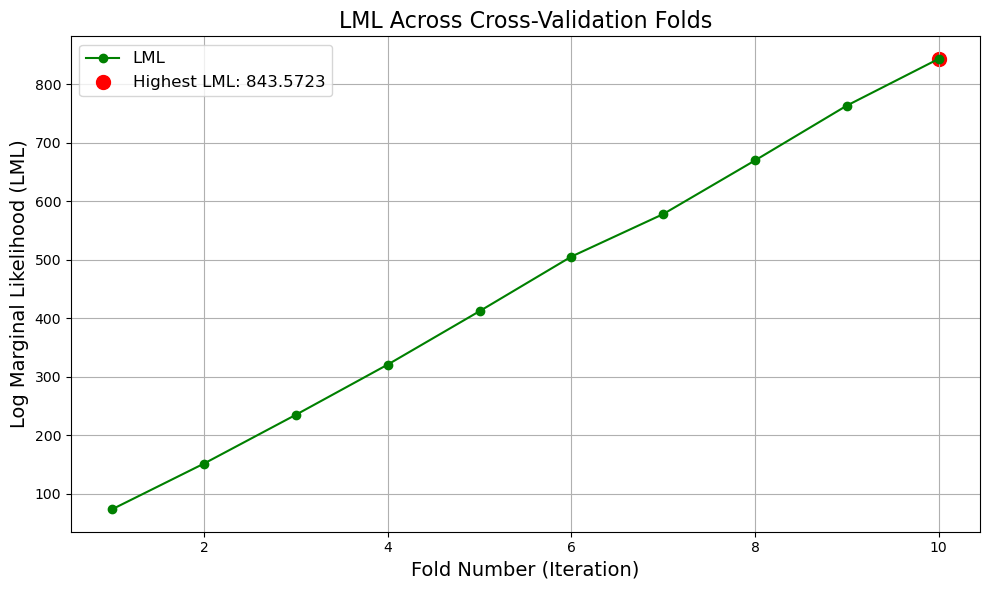

Best fold number: 10
Kernel parameters from best fold: 0.51**2 * RBF(length_scale=3.67e+03) + 0.242**2 * RationalQuadratic(alpha=0.00475, length_scale=75.1) + 1.81**2 * RBF(length_scale=3.7e+03) * ExpSineSquared(length_scale=1, periodicity=1) + 0.072**2 * RBF(length_scale=95.5) + WhiteKernel(noise_level=0.000203)


In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Find the index of the fold with the highest LML
max_lml_idx = np.argmax(lml)

# Plot LML across the folds
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(lml) + 1), lml, marker='o', linestyle='-', color='green', label='LML')
plt.xlabel('Fold Number (Iteration)', fontsize=14)
plt.ylabel('Log Marginal Likelihood (LML)', fontsize=14)
plt.title('LML Across Cross-Validation Folds', fontsize=16)

# Highlight the fold with the highest LML
plt.scatter(max_lml_idx + 1, lml[max_lml_idx], color='red', s=100, label=f'Highest LML: {lml[max_lml_idx]:.4f}')

# Add legend and grid
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the best performing parameters from the fold with the highest LML
print(f"Best fold number: {max_lml_idx + 1}")
print(f"Kernel parameters from best fold: {params[max_lml_idx]}")


In [103]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Define a kernel with a longer length scale and WhiteKernel for noise
kernel = RBF(length_scale=50) + WhiteKernel(noise_level=1.0)

# Create the GP model with the optimized kernel
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=False)

# Perform cross-validation with TimeSeriesSplit to monitor for overfitting
splitcv = TimeSeriesSplit(n_splits=5)
mse_train = []
mse_test = []

for train_index, test_index in splitcv.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the GP model
    gp_model.fit(x_train, y_train)

    # Make predictions
    y_pred_train, y_pred_test = gp_model.predict(x_train), gp_model.predict(x_test)

    # Calculate MSE for both training and testing data
    mse_train.append(mean_squared_error(y_train, y_pred_train))
    mse_test.append(mean_squared_error(y_test, y_pred_test))

# Compare MSE for training and testing
print(f"Training MSE: {np.mean(mse_train)}")
print(f"Test MSE: {np.mean(mse_test)}")


Training MSE: 0.0008266778094389516
Test MSE: 8.371132560415134
